### A Detailed Look at *topleft-corner* Regression Task

In [7]:
import os, sys
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt

from fastai2.basics import *
from fastai2.vision.all import *

In [8]:
path = untar_data(URLs.MNIST_TINY)

In [9]:
df = pd.DataFrame({'fn':[],'y':[]})

for digit_cat in os.listdir(path/'train'):
    
    tmp = [f'/train/{digit_cat}/{e}' for e in 
           os.listdir(path/'train'/str(digit_cat))] 
    df_tmp = pd.DataFrame({'fn': tmp})
    df_tmp['y'] = digit_cat
    df = pd.concat((df, df_tmp))
    
df['y'] = df['y'].astype('float')
df.reset_index(inplace=True)

In [10]:
def point_from_img(fn):

    img_np = np.array(Image.open(str(path) + fn))

    img_bool =         np.where(img_np > 0, 1, 0)
    row_sums =         img_bool.argmax(axis=1)
    binary_row_sums =  np.where(row_sums > 0, 1, 0)
    top_row_index =    binary_row_sums.tolist().index(1)
    top_row_values =   img_np[top_row_index,:]
    leftmost_index =   (top_row_values > 0).tolist().index(True)


    return (top_row_index, leftmost_index)

vals = [point_from_img(e) for e in df['fn']]
df_p = pd.DataFrame(vals, columns=['py','px'])
df = pd.concat((df,df_p ), axis=1)

In [11]:
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), PointBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader(['px', 'py'])
                  )

dls = dblock.dataloaders(df)

#### View Task

In [12]:
b =         dls.one_batch()
b_decoded = dls.decode_batch(b, max_n=64)

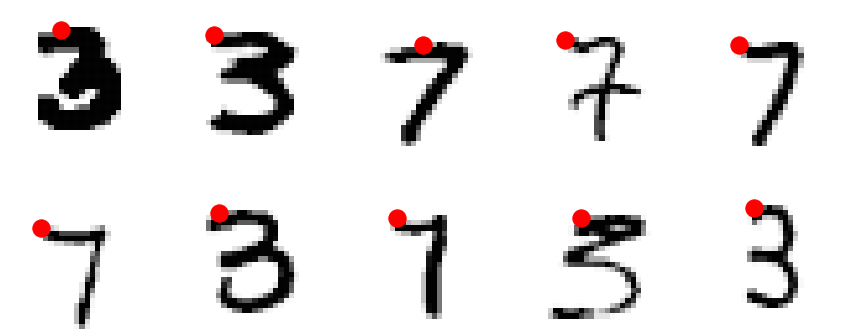

In [13]:
rows, cols = 2,5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols,3*rows))
axr = ax.ravel()

for i in range(rows*cols):

    b_decoded[i][0].show(ctx=axr[i])
    b_decoded[i][1].show(ctx=axr[i], s=300, marker='o', c='red')


In [14]:
len(dls.train.get_idxs()), len(dls.valid.get_idxs())

(568, 141)

In [15]:
prelearn_b = dls.one_batch()

#### Plotting position of y

In [16]:
import random
def epsilon(step=1):
    return random.uniform(-step,step)

In [17]:
xbar, ybar = df['px'].mean(), 28 - df['py'].mean()

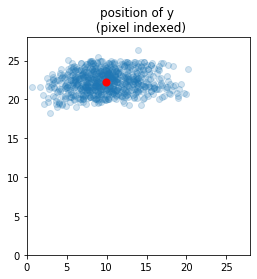

In [18]:
plt.figure(figsize=(4,4))
plt.scatter(x= [e + epsilon()    for e in df['px']], 
            y= [28-e + epsilon() for e in df['py']],
            alpha=0.2
       )
plt.scatter(xbar, ybar, marker='o', c='red', s=50)
plt.ylim(0,28)
plt.xlim(0,28)
plt.title('position of y \n (pixel indexed)');

In [19]:
y = torch.tensor([])
for _x, _y in dls.train:
    y = torch.cat((y,_y), dim=0)

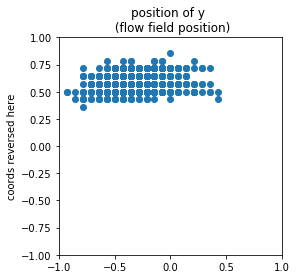

In [20]:
plt.figure(figsize=(4,4));
plt.scatter(y.view(-1,2)[:,0].tolist(), 
            y.view(-1,2)[:,1].mul(-1).tolist())
plt.ylim(-1,1);
plt.xlim(-1,1);
plt.ylabel('coords reversed here')
plt.title('position of y \n (flow field position)');

In [21]:
print('TopLeft / Bottom Right points in FlowField coords:')
(y.view(-1,2).min(dim=0).values, 
 y.view(-1,2).max(dim=0).values)

TopLeft / Bottom Right points in FlowField coords:


(tensor([-0.9286, -0.8571]), tensor([ 0.4286, -0.3571]))

### Modelling - Poor Results

epoch,train_loss,valid_loss,mse,time
0,3.625342,1.018334,1.018334,00:04


epoch,train_loss,valid_loss,mse,time
0,3.768481,0.423169,0.423169,00:05


epoch,train_loss,valid_loss,mse,time
0,3.899612,0.546532,0.546532,00:05


epoch,train_loss,valid_loss,mse,time
0,4.146295,1.344762,1.344762,00:05


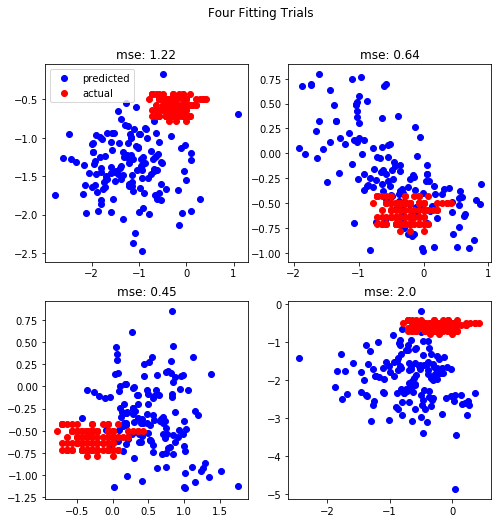

In [22]:
fig, ax = plt.subplots(2,2,figsize=(8,8))
axr = ax.ravel()
for i in range(4):
    
    learn = cnn_learner(dls, xresnet18, pretrained=True, metrics=[mse])
    learn.fit(1)
    
    preds = learn.get_preds(with_loss=True)
    
    axr[i].scatter(preds[0][:, 0], preds[0][:, 1], c='b')
    axr[i].scatter(preds[1].view(-1,2)[:, 0], preds[1].view(-1,2)[:, 1], c='r')
    axr[i].set_title(f'mse: {round(learn.loss.mean().tolist(),2)}')
    if i == 0:
        axr[i].legend(['predicted', 'actual']);
    
fig.suptitle('Four Fitting Trials');

##### Note: the change in color channels soerced by the learner

In [23]:
postlearn_b = dls.one_batch()

prelearn_b[0].shape, postlearn_b[0].shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 3, 28, 28]))

### Correct with `yrange`?

In [42]:
learn = cnn_learner(dls, 
                    xresnet18, 
                    pretrained=True, 
                    metrics=[mse],
                    yrange=(-1.,1.),
                   )
learn.fit(1)

epoch,train_loss,valid_loss,mse,time
0,4.012298,2.180402,2.180402,00:05


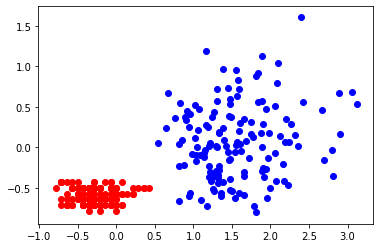

In [43]:
preds = learn.get_preds(with_loss=True)
    
plt.scatter(preds[0][:, 0], preds[0][:, 1], c='b')
plt.scatter(preds[1].view(-1,2)[:, 0], preds[1].view(-1,2)[:, 1], c='r')

In [49]:
learn = cnn_learner(dls, 
                    xresnet18, 
                    pretrained=True, 
                    metrics=[mse],
                    yrange=(-1.,1.),
                    batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                   )
learn.fine_tune(4, )

epoch,train_loss,valid_loss,mse,time
0,3.716268,2.139740,2.139740,00:08


epoch,train_loss,valid_loss,mse,time
0,3.244629,0.738684,0.738684,00:13
1,2.974114,0.631466,0.631466,00:13
2,2.876905,0.853288,0.853288,00:13
3,2.738071,0.993255,0.993255,00:14


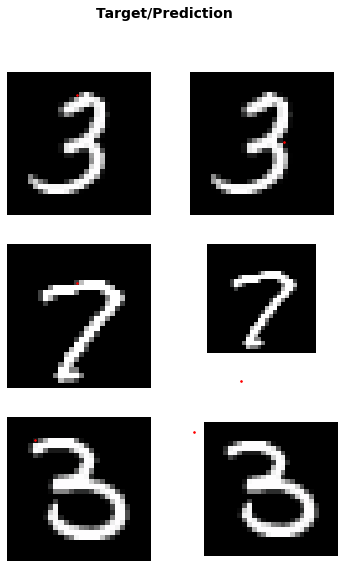

In [50]:
learn.show_results()

### Baseline Error

In [44]:
y = torch.tensor([])
for _x, _y in dls.train:
    y = torch.cat((y,_y), dim=0)

yhat = y.mean(dim=1).mean(dim=0)
yhat

yhat_vec = torch.tensor([[yhat.tolist()] for _ in range(len(y))])

mse(yhat_vec, y)

tensor(0.0367)

In [45]:
resid = yhat_vec - y

resid_sq = resid**2

mean_resid_sq = resid_sq.mean(dim=1).mean(dim=0)

mean_resid_sq.mean()

tensor(0.0367)

### Modelling - resnet34

In [15]:
learn34 = cnn_learner(dls, resnet34, pretrained=True, metrics=[mse])

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.033113110810518265)

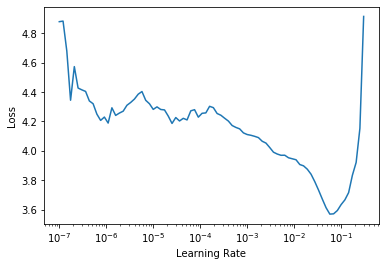

In [16]:
learn34.lr_find()

In [17]:
learn34.fit(6, lr=1e-4)

epoch,train_loss,valid_loss,mse,time
0,3.714164,0.909412,0.909412,00:07
1,3.715074,0.799663,0.799663,00:07
2,3.632791,0.929730,0.929730,00:07
3,3.672844,0.864244,0.864244,00:07
4,3.572034,0.750917,0.750917,00:07
5,3.517846,0.667924,0.667924,00:07


### Not actually the Jankiness
But here's the result of one to three channel conversion

In [110]:
img0 = dls.one_batch()[0][0]

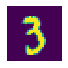

In [112]:
show_image(img0[0])

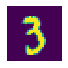

In [113]:
show_image(img0[1])

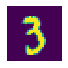

In [114]:
show_image(img0[2])

In [122]:
img0[2].mean(), img0[1].mean(), img0[0].mean()

(tensor(-1.2232), tensor(-1.4518), tensor(-1.5468))

In [123]:
[e for e in dir() if 'stats' in e]

['cifar_stats', 'imagenet_stats', 'mnist_stats']

In [119]:
mnist_stats

([0.131], [0.308])

In [121]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

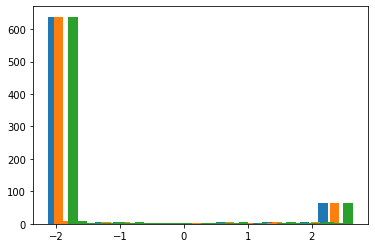

In [129]:
for i in range(3):
    plt.hist(img0[i].flatten(), bins=30);

### Debugging the first ConvLayer for Channels=3 vs Channels=1
The main problem: `dls` outputs one channel images until its passed into a learner with pretrained=True which converts the `dl` to a 3-channel. Before that there won't be dimensional accordance.

In [51]:
from torch.nn import Conv2d

In [53]:
cc = Conv2d(3,64, kernel_size=(7,7))

In [60]:
try:cc(b[0])
except Exception as e: print(e)

Given groups=1, weight of size 64 3 7 7, expected input[64, 1, 28, 28] to have 3 channels, but got 1 channels instead


In [64]:
b4 = mnist4_dls.one_batch()

try:
    ret = cc(b4[0])
    print(ret.shape)
except Exception as e: print(e)

torch.Size([64, 64, 22, 22])


In [65]:
b[0].shape

torch.Size([64, 1, 28, 28])

In [66]:
b4[0].shape

torch.Size([64, 3, 28, 28])

### Look at Model Arch

In [124]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  